# <font color="Red">マルチタスクで分類モデル作成<font>
## ニューラルネットワークを分岐さてMulti-task learning

In [1]:
#import os
#gpu_num = "3"
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

In [2]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, plot_12task_log, util
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict
from tuning import optuna_train_base, optuna_train_Tox21

sys.path.append(r'C:\Users\shingo\Git\keras-squeeze-excite-network')
import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

sys.path.append(r'C:\Users\shingo\Git\mixup-generator')
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ndimage.py: loaded as module file
my_generator.py: loaded as module file
get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file
base_predict.py: loaded as module file
optuna_train_base.py: loaded as module file
optuna_train.py: loaded as module file


## マルチラベルサンプルデータ
- https://blog.manash.me/multi-task-learning-in-keras-implementation-of-multi-task-classification-loss-f1d42da5c3f6
- classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])

[0 0 1 1 0]


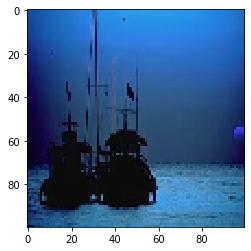

In [3]:
# Downloading and Viewing the dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

def load():
    f = h5py.File("01_code_test/dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()

plt.imshow(x_train[0])
print(y_train[0])

### パラメータ設定
- 画像サイズ: 100x100
- エポック数: 10
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル: SEInceptionV3
    - 全結合層: 1層（各層のニューロンの数は1024。各層にdropoutを0.5倍、重みの初期値はhe_normal(He の正規分布)、L2正則化=1e-4）
    - 重みは全層学習させる（fine-tuningなし）
    - 出力層の活性化関数: sigmoid（マルチラベルなので）
    - 出力層の重みの初期値はzero
- オプティマイザ: SGD
    - 学習率: 0.01
- データ水増し
    - 画像の剪断（shear_range=0.2）
    - 拡大縮小（zoom_range=[0.5, 1.9]）
    - 回転（rotation_range=60）
    - 上下反転（horizontal_flip=True）
    - 左右反転（vertical_flip=True）
    - 画像の一部矩形領域を隠す（random_erasing)
- callback
    - keras.callbacks.TerminateOnNaN: lossがNaNになった時に訓練を終了する
    - keras.callbacks.ModelCheckpoint: val_loss最少になるモデルを保存する
    - keras.callbacks.EarlyStopping: val_lossが100エポック更新されなければ学習停止する
    - cosine_annealing: lr*0.01 になるまで段階的に学習率下げる
    - keras.callbacks.CSVLogger: 各エポックの結果をcsvファイルに保存する
    

In [4]:
# 出力ディレクトリ
out_dir = r'D:\work\kaggle_data\multi_task_test'
os.makedirs(out_dir, exist_ok=True)

# batch_size
train_batch_size=50
valid_batch_size=50

# エポック数
epochs=10#250

# 入力層のサイズ
shape=[100, 100, 3]

# クラス数
num_classes=5
task_name_list=['desert', 'mountain', 'sea', 'sunset', 'trees']

# Fine-tuning する学習済みモデル
choice_model='SEInceptionV3'# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']

# 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
trainable=249

# GradCamでモデルの注目点を切りだす最後の畳み込み層
layer_name = 'multiply_11' #'mixed10'

## 全結合層のパラメータ
# pooling方法
FCpool='GlobalAveragePooling2D'
# 全結像層
FCnum=1 # [None,1,2,3,4,5]
# 全結合層のニューロンの数とdropout rate
Dence_1, Dropout_1, addBatchNorm_1, kernel_initializer_1, l2_rate_1=1024, 0.5, None, 'he_normal', 1e-4

# 出力層の活性化関数
activation = 'sigmoid'
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4

# optimizer のパラメータ
choice_optim='sgd'
lr = 0.01
decay = 0.0

# GPUの数
gpu_num = '1'
gpu_count=len(gpu_num.split(','))
print('gpu_count:', gpu_count)

# ImageDataGenerator のデータ水増しオプション
horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2

## コールバックの設定
# keras.callbacks.ModelCheckpoint
check_monitor='val_loss' # val_loss最少になるモデルを保存する

# keras.callbacks.EarlyStopping
early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
early_stopping_pati=100


gpu_count: 1


### モデル定義

In [5]:
model, orig_model = define_model.get_12branch_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                        , choice_model, trainable
                                                        , FCnum
                                                        , FCpool=FCpool
                                                        , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                        #, Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                        #, Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                        #, Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                        #, Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                        , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                        , activation=activation 
                                                        , gpu_count=gpu_count
                                                        #, skip_bn=skip_bn
                                                        , multi_n_node=1
                                                        )
# オプティマイザ
optim = define_model.get_optimizers(choice_optim, lr=lr, decay=decay)
#lr_metric = my_metric.get_lr_metric(optim)

# モデルコンパイル
model.compile(loss=[multi_loss.build_masked_loss(K.binary_crossentropy)
                    , multi_loss.build_masked_loss(K.binary_crossentropy)
                    , multi_loss.build_masked_loss(K.binary_crossentropy)
                    , multi_loss.build_masked_loss(K.binary_crossentropy)
                    , multi_loss.build_masked_loss(K.binary_crossentropy)]
              , optimizer=optim
              , metrics=['binary_accuracy', multi_loss.masked_accuracy])#, lr_metric])

# callback
cb = []

if gpu_count > 1:
    # マルチGPUでModelCheckpoint使うためのコールバック
    weight_dir = os.path.join(out_dir, 'model_weight')
    os.makedirs(weight_dir, exist_ok=True)
    cb.append(my_callback.MyCheckPoint(orig_model, weight_dir))
    
    # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
    train_batch_size = train_batch_size * gpu_count
    valid_batch_size = valid_batch_size * gpu_count
else:
    cb.append(keras.callbacks.TerminateOnNaN())
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(out_dir, 'best_model.h5'), monitor=check_monitor, save_best_only=True))#, monitor='val_acc'
    cb.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati , verbose=1))
    # 学習率をエポック増やすごとにコサインカーブのように上げ下げする
    ## 引数なしならlr*0.01まで下げるだけ
    cb.append(my_callback.cosine_annealing())
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(out_dir, 'learning_curve.png')))
    
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(out_dir, 'tsv_logger.tsv')))
    
cb.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history.tsv'), separator='\t'))
print(cb)

----- model_param -----
output_dir = D:\work\kaggle_data\multi_task_test
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = SEInceptionV3 249
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
Instructions for updating:
Colocations handled automatically by placer.
----- FC_layer -----
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.0001
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.0001
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.0001
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.0001
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer

In [6]:
# モデルのサマリー
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 49, 49, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 49, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 10, 10, 256)  0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 256)          0           mixed0[0][0]                     
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 1, 256)    0           global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_1 (D

__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 10, 10, 48)   13824       multiply_2[0][0]                 
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 10, 10, 96)   55296       activation_23[0][0]              
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 10, 10, 48)   144         conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 10, 10, 96)   288         conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 10, 10, 48)   0           batch_normalization_21[0][0]     
__________

                                                                 activation_30[0][0]              
                                                                 max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 768)          0           mixed3[0][0]                     
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 1, 768)    0           global_average_pooling2d_4[0][0] 
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1, 1, 48)     36864       reshape_4[0][0]                  
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1, 1, 768)    36864       dense_7[0][0]                    
__________

__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 1, 1, 768)    0           global_average_pooling2d_5[0][0] 
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1, 1, 48)     36864       reshape_5[0][0]                  
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1, 1, 768)    36864       dense_9[0][0]                    
__________________________________________________________________________________________________
multiply_5 (Multiply)           (None, 4, 4, 768)    0           mixed4[0][0]                     
                                                                 dense_10[0][0]                   
__________________________________________________________________________________________________
conv2d_45 

__________________________________________________________________________________________________
dense_12 (Dense)                (None, 1, 1, 768)    36864       dense_11[0][0]                   
__________________________________________________________________________________________________
multiply_6 (Multiply)           (None, 4, 4, 768)    0           mixed5[0][0]                     
                                                                 dense_12[0][0]                   
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 4, 4, 160)    122880      multiply_6[0][0]                 
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 4, 4, 160)    480         conv2d_55[0][0]                  
__________________________________________________________________________________________________
activation

                                                                 dense_14[0][0]                   
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 4, 4, 192)    147456      multiply_7[0][0]                 
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 4, 4, 192)    576         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 4, 4, 192)    0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 4, 4, 192)    258048      activation_65[0][0]              
__________________________________________________________________________________________________
batch_norm

batch_normalization_73 (BatchNo (None, 4, 4, 192)    576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 4, 4, 192)    0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 4, 4, 192)    258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 4, 4, 192)    576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 4, 4, 192)    0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 

__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 1, 1, 384)    1152        conv2d_80[0][0]                  
__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 1, 1, 384)    1152        conv2d_83[0][0]                  
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 1, 1, 384)    1152        conv2d_84[0][0]                  
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 1, 1, 192)    245760      average_pooling2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 1, 1, 320)    960         conv2d_77[0][0]                  
__________

__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, 1, 1, 384)    1152        conv2d_93[0][0]                  
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 1, 1, 192)    393216      average_pooling2d_9[0][0]        
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, 1, 1, 320)    960         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_88 (Activation)      (None, 1, 1, 384)    0           batch_normalization_88[0][0]     
__________________________________________________________________________________________________
activation_89 (Activation)      (None, 1, 1, 384)    0           batch_normalization_89[0][0]     
__________

__________________________________________________________________________________________________
task4_pred (Dense)              (None, 1)            1025        task4_FC1_dropout[0][0]          
Total params: 33,949,733
Trainable params: 25,455,429
Non-trainable params: 8,494,304
__________________________________________________________________________________________________


In [7]:
# モデルのレイヤー名と番号
count= 0
for layer in model.layers:
    print(count, layer.name)
    count+=1

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 global_average_pooling2d_1
42 reshape_1
43 dense_1
44 dense_2
45 multiply_1
46 conv2d_16
47 batch_normalization_16
48 activation_16
49 conv2d_14
50 conv2d_17
51 batch_normalization_14
52 batch_normalization_17
53 activation_14
54 activation_17
55 average_pooling2d_2
56 conv2d_13


### データ管理クラス定義
- d_cls.X_train: train set の画像データ（d_cls.X_train.shape:[11764, 331, 331, 3]）
- d_cls.X_valid: validation set の画像データ（d_cls.X_valid.shape:[296, 331, 331, 3]）
- d_cls.X_test: test set の画像データ（d_cls.X_test.shape:[647, 331, 331, 3]）
- d_cls.train_gen: train set のImageDataGenerator
- d_cls.valid_gen: validation set のImageDataGenerator

In [8]:
%%time
d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size, valid_batch_size)
d_cls.X_train = x_train
d_cls.y_train = y_train
d_cls.X_valid = x_test
d_cls.y_valid = y_test

# ImageDataGenerator のオプションを辞書型で詰める
# get_random_eraserでd_clsの値使うのでここで宣言しないとエラーになる
IDG_options={'horizontal_flip': horizontal_flip
             , 'vertical_flip': vertical_flip
             , 'rotation_range': rotation_range
             , 'zoom_range': zoom_range
             , 'shear_range': shear_range
             , 'preprocessing_function': get_random_eraser(v_l=np.min(d_cls.X_train), v_h=np.max(d_cls.X_train))
            }

d_cls.create_generator(IDG_options=IDG_options)

----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 60, 'zoom_range': [0.5, 1.9], 'shear_range': 0.2, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x0000017C5853A6A8>}
Wall time: 192 ms


(<keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator at 0x17e00b0da58>,
 <keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator at 0x17e00b0dac8>)

In [9]:
X,y = next(d_cls.train_gen)
print(X.shape)
print(y.shape)
display(y)

(50, 100, 100, 3)
(50, 5)


array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0,

In [10]:
y_conv = []
for i in range(y.shape[1]):
    y_conv.append(y[:,i])
y_conv

[array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1], dtype=int64),
 array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0], dtype=int64),
 array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0], dtype=int64),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int64)]

In [11]:
_gen = get_train_valid_test.generator_12output(d_cls.train_gen)
X,y = next(_gen)
print(X.shape)
print(np.array(y).shape)
print(y[0].shape)
display(y)

(50, 100, 100, 3)
(5, 50)
(50,)


[array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0], dtype=int64),
 array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0], dtype=int64),
 array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1], dtype=int64),
 array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0], dtype=int64)]

In [12]:
d_cls.train_gen = get_train_valid_test.multi_task_generator_wrapper(d_cls.train_gen)
X,y = next(d_cls.train_gen)
print(X.shape)
print(np.array(y).shape)
print(y[0].shape)
display(y)

d_cls.valid_gen = get_train_valid_test.multi_task_generator_wrapper(d_cls.valid_gen)
X,y = next(d_cls.valid_gen)
print(X.shape)
print(len(y))
print(y[0].shape)

(50, 100, 100, 3)
(5, 50)
(50,)


[array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0], dtype=int64),
 array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0], dtype=int64),
 array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1], dtype=int64)]

(50, 100, 100, 3)
5
(50,)


### 学習実行

In [13]:
%%time
model.fit_generator(d_cls.train_gen
                    , steps_per_epoch=d_cls.train_steps_per_epoch()
                    , epochs=epochs
                    , validation_data=d_cls.valid_gen
                    , validation_steps=d_cls.valid_steps_per_epoch()
                    , callbacks=cb
                    , verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 16s - loss: 3.9123 - task0_pred_loss: 0.5417 - task1_pred_loss: 0.5518 - task2_pred_loss: 0.6198 - task3_pred_loss: 0.5669 - task4_pred_loss: 0.6084 - task0_pred_binary_accuracy: 0.7931 - task0_pred_masked_accuracy: 0.7931 - task1_pred_binary_accuracy: 0.7831 - task1_pred_masked_accuracy: 0.7831 - task2_pred_binary_accuracy: 0.7006 - task2_pred_masked_accuracy: 0.7006 - task3_pred_binary_accuracy: 0.7600 - task3_pred_masked_accuracy: 0.7600 - task4_pred_binary_accuracy: 0.7263 - task4_pred_masked_accuracy: 0.7263 - val_loss: 5.7133 - val_task0_pred_loss: 0.6595 - val_task1_pred_loss: 1.2910 - val_task2_pred_loss: 0.6472 - val_task3_pred_loss: 0.9119 - val_task4_pred_loss: 1.1806 - val_task0_pred_binary_accuracy: 0.7900 - val_task0_pred_masked_accuracy: 0.7900 - val_task1_pred_binary_accuracy: 0.7625 - val_task1_pred_masked_accuracy: 0.7625 - val_task2_pred_binary_accuracy: 0.7425 - val_task2_pred_masked_accuracy: 0.7425 - va

C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\model\my_callback.py:159: MatplotlibDeprecationWarning:


The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.



Epoch 3/10
 - 4s - loss: 3.6844 - task0_pred_loss: 0.4882 - task1_pred_loss: 0.5304 - task2_pred_loss: 0.5995 - task3_pred_loss: 0.4856 - task4_pred_loss: 0.5592 - task0_pred_binary_accuracy: 0.7881 - task0_pred_masked_accuracy: 0.7881 - task1_pred_binary_accuracy: 0.7669 - task1_pred_masked_accuracy: 0.7669 - task2_pred_binary_accuracy: 0.7063 - task2_pred_masked_accuracy: 0.7063 - task3_pred_binary_accuracy: 0.7956 - task3_pred_masked_accuracy: 0.7956 - task4_pred_binary_accuracy: 0.7444 - task4_pred_masked_accuracy: 0.7444 - val_loss: 4.0844 - val_task0_pred_loss: 0.5331 - val_task1_pred_loss: 0.9219 - val_task2_pred_loss: 0.5892 - val_task3_pred_loss: 0.4429 - val_task4_pred_loss: 0.5763 - val_task0_pred_binary_accuracy: 0.7900 - val_task0_pred_masked_accuracy: 0.7900 - val_task1_pred_binary_accuracy: 0.7625 - val_task1_pred_masked_accuracy: 0.7625 - val_task2_pred_binary_accuracy: 0.7425 - val_task2_pred_masked_accuracy: 0.7425 - val_task3_pred_binary_accuracy: 0.7850 - val_task3_

Wall time: 1min 43s


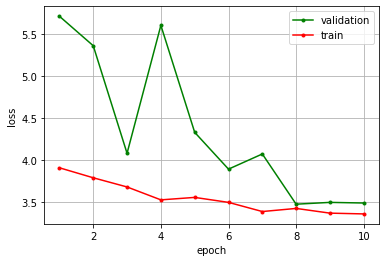

<Figure size 432x288 with 0 Axes>

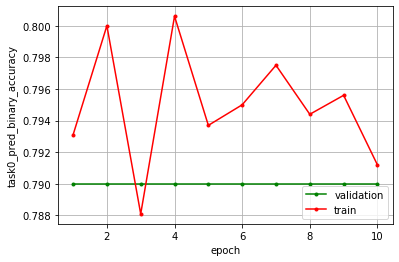

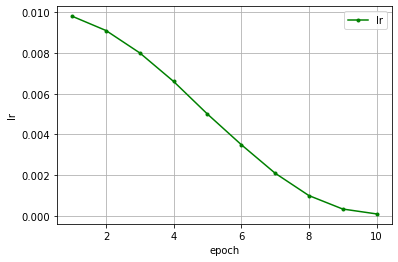

<Figure size 432x288 with 0 Axes>

In [14]:
import os
import matplotlib
#Jupyterでインライン表示するための宣言
%matplotlib inline
#plot_log.plot_results(out_dir, os.path.join(out_dir, 'history.tsv'))
plot_log.plot_results(out_dir, os.path.join(out_dir, 'tsv_logger.tsv'), acc_metric='task0_pred_binary_accuracy')

### 推論実行

In [15]:
print(d_cls.X_train[0:1].shape)
model.predict(d_cls.X_train[0:1])

(1, 100, 100, 3)


[array([[0.3741475]], dtype=float32),
 array([[0.06096582]], dtype=float32),
 array([[0.2500974]], dtype=float32),
 array([[0.5565934]], dtype=float32),
 array([[0.11452327]], dtype=float32)]

### test set（今回はtest set なし）
- タスクごとの混同行列とROC図も作成し、./< out_dir >/predict/test ディレクトリに出力

In [16]:
#%%time
## -------- 推論 --------
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
## 推論結果出力先
#out_predict_dir = os.path.join(out_dir, 'predict/test')
#
## 出力層のニューラルネットワークに分岐がない場合のpredict
#y_test_list, y_pred_list = multi_predict.no_branch_set_predict(model, d_cls.X_test, d_cls.y_test, out_predict_dir)
#
## -------- 混同行列 --------
## 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
#classes = [0,1,-1]
#
## タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
#conf_matrix.binary_multi_confmx(classes, y_test_list, y_pred_list, out_predict_dir)

In [17]:
## -------- ROC_AUC --------
## タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
#roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_test_list, y_pred_list)

### test set GradCam
- GradCam実行した画像は./< out_dir >/grad_cam/ ディレクトリに出力

#### ためしに1件実行

In [18]:
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる
#
## GradCam出力先
#out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test')
#
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
## 3次元numpy.array型の画像データ（*1./255.前）
#x = d_cls.X_test[0]*255.0
#input_img_name = 'test0'
#
#y_true = d_cls.y_test[0]
#
## 1画像について各タスクのGradCamを計算
#grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

#### test set 全件GradCam実行（十数時間かかる）

In [19]:
#%%time
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる
#
## GradCam出力先
#out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test_all')
#
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
#for i,  x in enumerate(d_cls.X_test):
#    # 3次元numpy.array型の画像データ（*1./255.前）
#    x = x*255.0
#
#    # ファイル名
#    file_path = test_files[test_files.index[i]]# test_filesはindexが0始まりではないので.index[i]で要素アクセス
#    input_img_name = os.path.basename(file_path)
#    print('input_img_name:', input_img_name)
#    
#    # 正解ラベル
#    y_true = d_cls.y_test[i]
#
#    # 1画像について各タスクのGradCamを計算
#    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])
#
## 確認用に1枚表示
#plt.figure(figsize=(6, 4))
#plt.imshow(grad_cam_img)
#plt.show()

### validation set
- タスクごとの混同行列とROC図も作成し、./< out_dir >/predict/validation ディレクトリに出力

C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\predicter\multi_predict.py:58: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\pandas\core\indexing.py:822: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



------------------------------------
out_dir: D:\work\kaggle_data\multi_task_test\predict/validation\confusion_matrix\task0


C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



              precision    recall  f1-score   support

           0       0.79      1.00      0.88       316
           1       0.00      0.00      0.00        84
          -1       0.00      0.00      0.00         0

   micro avg       0.79      0.79      0.79       400
   macro avg       0.26      0.33      0.29       400
weighted avg       0.62      0.79      0.70       400

Confusion matrix, without normalization


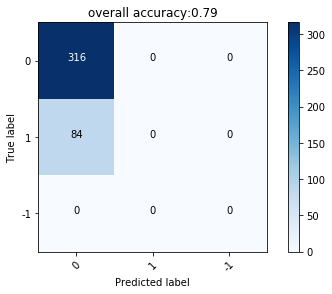

------------------------------------
out_dir: D:\work\kaggle_data\multi_task_test\predict/validation\confusion_matrix\task1
              precision    recall  f1-score   support

           0       0.76      1.00      0.87       305
           1       0.00      0.00      0.00        95
          -1       0.00      0.00      0.00         0

   micro avg       0.76      0.76      0.76       400
   macro avg       0.25      0.33      0.29       400
weighted avg       0.58      0.76      0.66       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

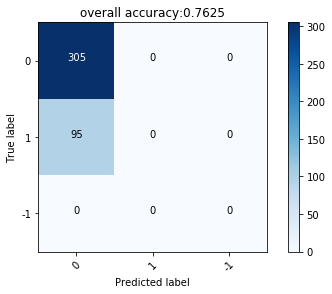

------------------------------------
out_dir: D:\work\kaggle_data\multi_task_test\predict/validation\confusion_matrix\task2
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       297
           1       0.50      0.01      0.02       103
          -1       0.00      0.00      0.00         0

   micro avg       0.74      0.74      0.74       400
   macro avg       0.41      0.34      0.29       400
weighted avg       0.68      0.74      0.64       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

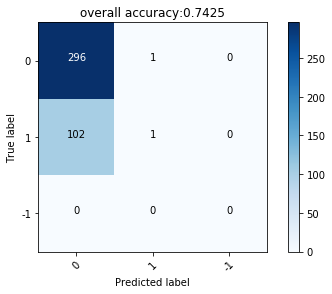

------------------------------------
out_dir: D:\work\kaggle_data\multi_task_test\predict/validation\confusion_matrix\task3
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       313
           1       0.75      0.48      0.59        87
          -1       0.00      0.00      0.00         0

   micro avg       0.85      0.85      0.85       400
   macro avg       0.54      0.48      0.50       400
weighted avg       0.84      0.85      0.84       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

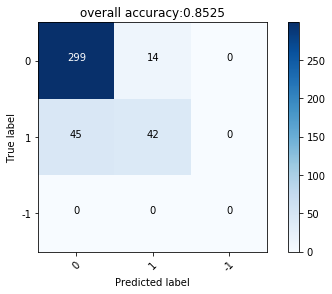

------------------------------------
out_dir: D:\work\kaggle_data\multi_task_test\predict/validation\confusion_matrix\task4
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       274
           1       0.72      0.52      0.60       126
          -1       0.00      0.00      0.00         0

   micro avg       0.79      0.79      0.79       400
   macro avg       0.51      0.47      0.48       400
weighted avg       0.78      0.79      0.77       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

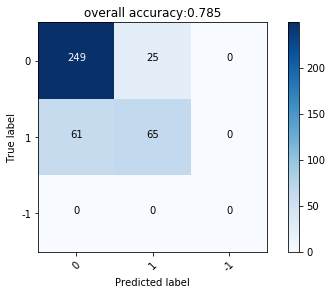

Wall time: 19.5 s


<Figure size 432x288 with 0 Axes>

In [20]:
%%time
# -------- 推論 --------
model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

# 推論結果出力先
out_predict_dir = os.path.join(out_dir, 'predict/validation')

# 出力層のニューラルネットワークに分岐がない場合のpredict
y_valid_list, y_pred_list = multi_predict.branch_set_predict(model, d_cls.X_valid, d_cls.y_valid, out_predict_dir)

# -------- 混同行列 --------
# 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
classes = [0,1,-1]

# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
conf_matrix.binary_multi_confmx(classes, y_valid_list, y_pred_list, out_predict_dir)

------------------------------------
out_png: D:\work\kaggle_data\multi_task_test\predict/validation\ROC_curve.png
desert_roc_auc: 0.7412597950572635
mountain_roc_auc: 0.6811044003451251
sea_roc_auc: 0.7000098068059233
sunset_roc_auc: 0.8691197532224303
trees_roc_auc: 0.8074383037886687
mean_auc: 0.7596157764180012
std_auc: 0.06975932814445485


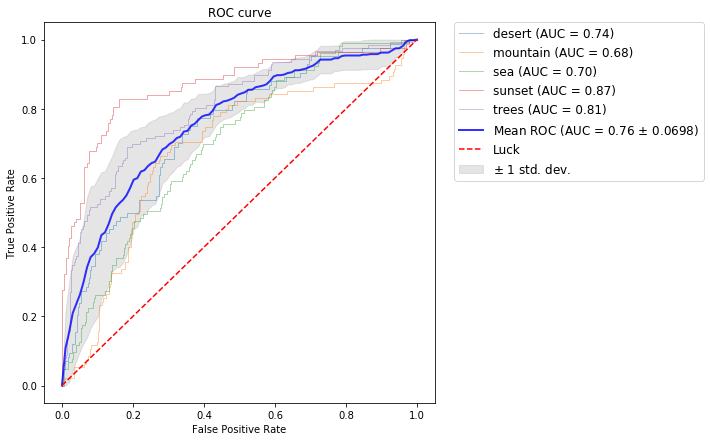

<Figure size 432x288 with 0 Axes>

In [21]:
# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_valid_list, y_pred_list
                  , task_name_list=task_name_list
                  )

### validation set GradCam
- GradCam実行した画像は./< out_dir >/grad_cam/ ディレクトリに出力

#### ためしに1件実行

C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\predicter\grad_cam.py:80: RuntimeWarning:

invalid value encountered in true_divide



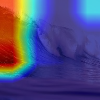

In [22]:
K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation')

model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})

# 3次元numpy.array型の画像データ（*1./255.前）
x = d_cls.X_valid[0]*255.0
input_img_name = 'valid0'

y_true = d_cls.y_valid[0]

# 1画像について各タスクのGradCamを計算
layer_name = 'activation_75'
grad_cam.branch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

#### validation set 全件GradCam実行（数時間かかる）

In [23]:
#%%time
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる
#
## GradCam出力先
#out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation_all')
#
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
#for i,  x in enumerate(d_cls.X_valid):
#    # 3次元numpy.array型の画像データ（*1./255.前）
#    x = x*255.0
#    
#    # ファイル名
#    file_path = validation_files[validation_files.index[i]]# validation_filesはindexが0始まりではないので.index[i]で要素アクセス
#    input_img_name = os.path.basename(file_path)
#    print('input_img_name:', input_img_name)
#    
#    # 正解ラベル
#    y_true = d_cls.y_valid[i]
#
#    # 1画像について各タスクのGradCamを計算
#    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])
#
## 確認用に1枚表示
#plt.figure(figsize=(6, 4))
#plt.imshow(grad_cam_img)
#plt.show()